In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
sns.set_context('paper')
sns.set(font_scale=1.2)

/home/gjones/anaconda/envs/pmc/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
records = np.load('/artemis/readout/archive/2016-12-12-stanford-almn-res2-temp-sweep.npz')['records']

In [4]:
Q = records['res_Q']
Q_err = records['res_Q_error']
iQ = 1/Q
iQi = 1/records['res_Q_i']
iQerr = Q_err/Q**2
tt = records['package_temperature']
f_0 = records['res_f_0']
f_0_err = records['res_f_0_error']
x = 1-f_0/f_0.max()
x_err = f_0_err/f_0.max()

In [5]:
from scipy.constants import c, h, k as k_B, pi
from scipy.special import i0,k0,psi
N0 = 1.72e10

def qiqp(T,alpha_k=1,Tc=.73,f=150e6):
    delta = Tc*k_B*1.76
    return (pi*np.exp(delta/(k_B*T))/
           (4*alpha_k*np.sinh(h*f/(2*k_B*T))*
           k0(h*f/(2*k_B*T))))
def iqitls(T,f=150e6):
    return np.tanh(h * f / (2 * k_B * T))

def iqi(T,alpha_k=1,Tc=.73,f=150e6,L0=0,tls_factor=0):
    return (1/qiqp(T,alpha_k,Tc,f)) + iqitls(T,f)*tls_factor + L0

def xqp(T,alpha_k=1,Tc=.73,f=150e6):
    delta = Tc*k_B*1.76
    return ((alpha_k/(2*delta))*
           (1+(np.sqrt(2*delta/(pi*k_B*T))*
              np.exp(-h*f/(2*k_B*T))*
              i0(h*f/(2*k_B*T))))*
            np.sqrt(2*pi*k_B*T*delta)*np.exp(-delta/(k_B*T)))
def xtls(T,f=150e6):
    return pi * (psi(0.5 + h * f / (2j * pi * k_B * T)).real - np.log(h * f / (k_B * T)))

def xtotal(T,alpha_k=1,Tc=.73,f=150e6,x0=0,tls_factor=0):
    return xqp(T,alpha_k,Tc,f) - tls_factor*xtls(T,f) + x0

def exp_model(T,scale,shift,offset):
    return np.exp(T/scale+shift) + offset

T = np.linspace(50e-3,250e-3,100)

In [6]:
nominal_tls = np.array([  6.93970797e-01,   1.67801062e-01,   1.06318252e-01,
        -7.31699556e+00,  -7.19529211e+00,   3.65098640e-06,
         5.27108976e-06,   1.29435595e+02])

nominal_exp = array([  2.07565982e-02,  -1.66905351e+01,  -1.97755323e+01,
        -3.03544701e-06,   5.12540650e-06,   5.27963253e+01])

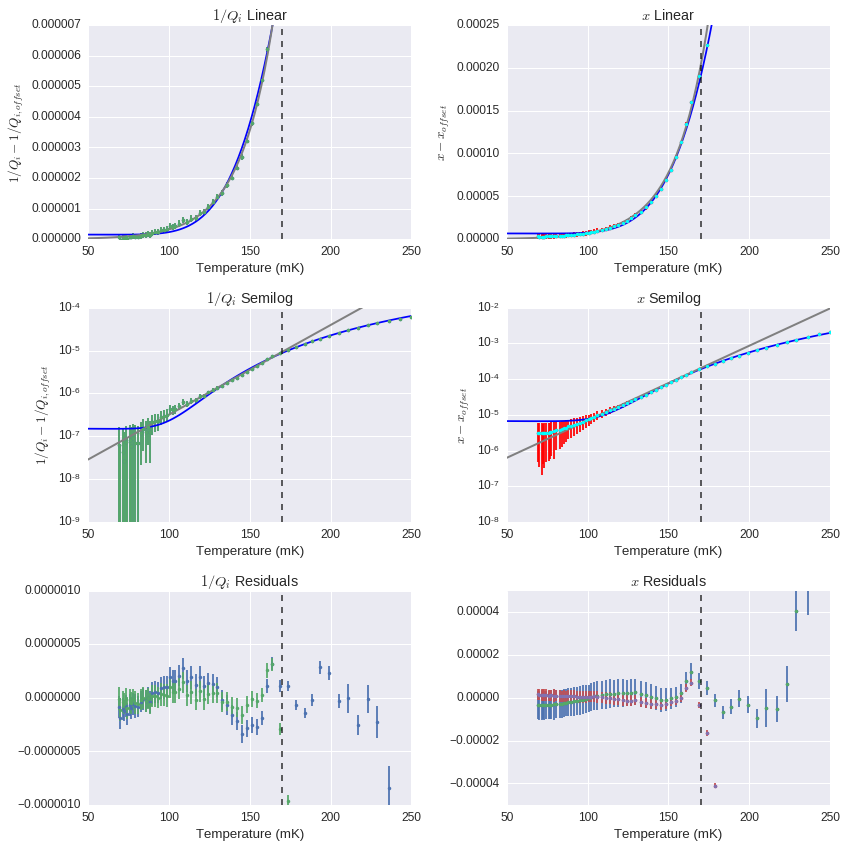

In [63]:
scale,shift_x,shift_q,offset_x,offset_q,efacx = nominal_exp

def eval_params_tls(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal_tls
#tls_x=-10
#tls_q=-10
nominal_copy = np.array([Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx])
#offset_q = iqi0
#offset_x = x0
#efacx=200
fig,axs=subplots(3,2,figsize=(12,12))
ax1a,ax2a,ax1b,ax2b,ax3,ax4 = axs.flatten()
for ax1,ax2 in [(ax1a,ax2a),(ax1b,ax2b)]:
#    for k in range(100):
#        params = samp.flatchain[np.random.randint(0,samp.flatchain.shape[0]-1),:]
#        iqip,xp = eval_params(params,T)
#        ax1.plot(T*1000,iqip-offset_q,alpha=.05,color='k')
#        ax2.plot(T*1000,xp-offset_x,alpha=.05,color='k')
    iqip,xp = eval_params_tls(nominal_copy,T)
    ax1.plot(T*1000,iqip-offset_q,color='blue')
    ax2.plot(T*1000,xp-offset_x,color='blue')

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.')
    #ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='r',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='')
    ax1.set_ylabel('$1/Q_i-1/Q_{i,offset}$')
    ax2.set_ylabel('$x-x_{offset}$')
ax1b.set_yscale('log')
ax2b.set_yscale('log')
ax1b.set_ylim(1e-9,1e-4)
ax2b.set_ylim(1e-8,1e-2)
ax1a.set_ylim(1e-9,7e-6)
ax2a.set_ylim(1e-8,2.5e-4)

iqi_nom,x_nom = eval_params_tls(nominal_copy,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.',elinewidth=0)
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.',elinewidth=0)
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.',elinewidth=0)
ax3.set_ylim(-1e-6,1e-6)
ax4.set_ylim(-5e-5,5e-5)
for ax in axs.flatten():
#    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
ax1a.set_title('$1/Q_i$ Linear')
ax2a.set_title('$x$ Linear')
ax1b.set_title('$1/Q_i$ Semilog')
ax2b.set_title('$x$ Semilog')
ax3.set_title('$1/Q_i$ Residuals')
ax4.set_title('$x$ Residuals')



def eval_params_exp(params,T):
    scale,shift_x,shift_q,offset_x,offset_q,efacx = params
    efacq = 1
    #print params
    iqi_predict = exp_model(T,scale=scale,shift=shift_q,offset=offset_q)
    x_predict = exp_model(T,scale=scale,shift=shift_x,offset=offset_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
scale,shift_x,shift_q,offset_x,offset_q,efacx = nominal_exp
#offset_q = iqi0
#offset_x = x0

#Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal
#efacx=200
for ax1,ax2 in [(ax1a,ax2a),(ax1b,ax2b)]:
    iqip,xp = eval_params_exp(nominal_exp,T)
    ax1.plot(T*1000,iqip-offset_q,color='gray',lw=2)
    ax2.plot(T*1000,xp-offset_x,color='gray',lw=2)

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='r',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='',color='cyan',marker='.')
    
iqi_nom,x_nom = eval_params_exp(nominal_exp,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.',elinewidth=0)
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.',elinewidth=0)
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.',elinewidth=0)
#ax3.set_ylim(-1e-6,1e-6)
#ax4.set_ylim(-5e-5,5e-5)
for ax in axs.flatten():
    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()


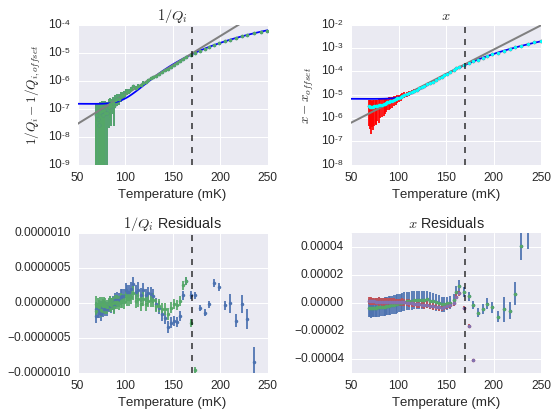

In [48]:
scale,shift_x,shift_q,offset_x,offset_q,efacx = nominal_exp

def eval_params_tls(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal_tls
#tls_x=-10
#tls_q=-10
nominal_copy = np.array([Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx])
#offset_q = iqi0
#offset_x = x0
#efacx=200
fig,axs=subplots(2,2,figsize=(8,6))
ax1b,ax2b,ax3,ax4 = axs.flatten()
for ax1,ax2 in [(ax1b,ax2b)]:
#    for k in range(100):
#        params = samp.flatchain[np.random.randint(0,samp.flatchain.shape[0]-1),:]
#        iqip,xp = eval_params(params,T)
#        ax1.plot(T*1000,iqip-offset_q,alpha=.05,color='k')
#        ax2.plot(T*1000,xp-offset_x,alpha=.05,color='k')
    iqip,xp = eval_params_tls(nominal_copy,T)
    ax1.plot(T*1000,iqip-offset_q,color='blue')
    ax2.plot(T*1000,xp-offset_x,color='blue')

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.')
    #ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='r',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='')
    ax1.set_ylabel('$1/Q_i-1/Q_{i,offset}$')
    ax2.set_ylabel('$x-x_{offset}$')
ax1b.set_yscale('log')
ax2b.set_yscale('log')
ax1b.set_ylim(1e-9,1e-4)
ax2b.set_ylim(1e-8,1e-2)
#ax1a.set_ylim(1e-9,7e-6)
#ax2a.set_ylim(1e-8,2.5e-4)

iqi_nom,x_nom = eval_params_tls(nominal_copy,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.')
ax3.set_ylim(-1e-6,1e-6)
ax4.set_ylim(-5e-5,5e-5)
for ax in axs.flatten():
#    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
#ax1a.set_title('$1/Q_i$ Linear')
#ax2a.set_title('$x$ Linear')
ax1b.set_title('$1/Q_i$')
ax2b.set_title('$x$')
ax3.set_title('$1/Q_i$ Residuals')
ax4.set_title('$x$ Residuals')



def eval_params_exp(params,T):
    scale,shift_x,shift_q,offset_x,offset_q,efacx = params
    efacq = 1
    #print params
    iqi_predict = exp_model(T,scale=scale,shift=shift_q,offset=offset_q)
    x_predict = exp_model(T,scale=scale,shift=shift_x,offset=offset_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
scale,shift_x,shift_q,offset_x,offset_q,efacx = nominal_exp
#Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal
#efacx=200
for ax1,ax2 in [(ax1b,ax2b)]:
    iqip,xp = eval_params_exp(nominal_exp,T)
    ax1.plot(T*1000,iqip-offset_q,color='gray',lw=2)
    ax2.plot(T*1000,xp-offset_x,color='gray',lw=2)

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='r',marker='.')
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='',color='cyan',marker='.')
    
iqi_nom,x_nom = eval_params_exp(nominal_exp,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.')
#ax3.set_ylim(-1e-6,1e-6)
#ax4.set_ylim(-5e-5,5e-5)
for ax in axs.flatten():
    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()
#fig.savefig('/home/gjones/paper_plots/iqi_x_both_fits_4_panel.pdf',bbox_inches='tight')

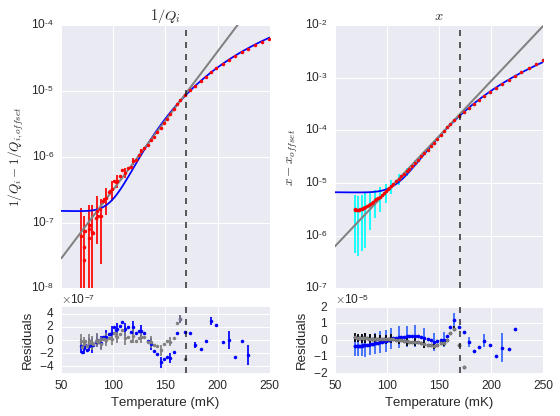

In [150]:
errorevery = 3

from matplotlib import ticker

scale_pow = 2
def my_formatter_fun(x, p):
    return "%.2f" % (x * (10 ** scale_pow))

scale,shift_x,shift_q,offset_x,offset_q,efacx = nominal_exp

def eval_params_tls(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal_tls
#tls_x=-10
#tls_q=-10
nominal_copy = np.array([Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx])
#offset_q = iqi0
#offset_x = x0
#efacx=200
gs = matplotlib.gridspec.GridSpec(2,2,height_ratios=[4,1])
fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax1b = fig.add_subplot(gs[0])
ax2b = fig.add_subplot(gs[1])
axs = [ax1b,ax2b,ax3,ax4]
ax1b.xaxis.set_ticklabels([])
ax2b.xaxis.set_ticklabels([])

fig.tight_layout(h_pad=0)
for ax1,ax2 in [(ax1b,ax2b)]:
#    for k in range(100):
#        params = samp.flatchain[np.random.randint(0,samp.flatchain.shape[0]-1),:]
#        iqip,xp = eval_params(params,T)
#        ax1.plot(T*1000,iqip-offset_q,alpha=.05,color='k')
#        ax2.plot(T*1000,xp-offset_x,alpha=.05,color='k')
    iqip,xp = eval_params_tls(nominal_copy,T)
    ax1.plot(T*1000,iqip-offset_q,color='blue')
    ax2.plot(T*1000,xp-offset_x,color='blue')

    #ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.',errorevery=errorevery)
    #ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='r',marker='.')
    #ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='',errorevery=errorevery)
    ax1.set_ylabel('$1/Q_i-1/Q_{i,offset}$')
    ax2.set_ylabel('$x-x_{offset}$')
ax1b.set_yscale('log')
ax2b.set_yscale('log')
ax1b.set_ylim(1e-8,1e-4)
ax2b.set_ylim(1e-7,1e-2)
#ax1a.set_ylim(1e-9,7e-6)
#ax2a.set_ylim(1e-8,2.5e-4)

iqi_nom,x_nom = eval_params_tls(nominal_copy,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.',errorevery=errorevery,color='b')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.',errorevery=errorevery,color='#3366ff')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.',errorevery=errorevery,color='b')
for ax in [ax3,ax4]:
#    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
    ax.set_ylabel('Residuals')
#ax1a.set_title('$1/Q_i$ Linear')
#ax2a.set_title('$x$ Linear')
ax1b.set_title('$1/Q_i$')
ax2b.set_title('$x$')
ax1b.xaxis.set_ticklabels([])
ax2b.xaxis.set_ticklabels([])

#ax3.set_title('$1/Q_i$ Residuals')
#ax4.set_title('$x$ Residuals')



def eval_params_exp(params,T):
    scale,shift_x,shift_q,offset_x,offset_q,efacx = params
    efacq = 1
    #print params
    iqi_predict = exp_model(T,scale=scale,shift=shift_q,offset=offset_q)
    x_predict = exp_model(T,scale=scale,shift=shift_x,offset=offset_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
scale,shift_x,shift_q,offset_x,offset_q,efacx = nominal_exp
#Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal
#efacx=200
for ax1,ax2 in [(ax1b,ax2b)]:
    iqip,xp = eval_params_exp(nominal_exp,T)
    ax1.plot(T*1000,iqip-offset_q,color='gray',lw=2)
    ax2.plot(T*1000,xp-offset_x,color='gray',lw=2)

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',color='r',marker='.',errorevery=errorevery)
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='cyan',marker='.',errorevery=errorevery)
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='',color='r',marker='.',errorevery=errorevery)
    
iqi_nom,x_nom = eval_params_exp(nominal_exp,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.',errorevery=errorevery,color='gray')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.',errorevery=errorevery,color='k')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.',errorevery=errorevery,color='gray')
ax3.set_ylim(-5e-7,5e-7)
ax4.set_ylim(-2e-5,2e-5)
ax3.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax4.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax3.yaxis.major.formatter._useMathText=True
ax4.yaxis.major.formatter._useMathText=True
for ax in axs:
    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlim(50,250)

fig.tight_layout(h_pad=0)
#fig.subplots_adjust(hspace=0)
fig.savefig('/home/gjones/paper_plots/iqi_x_both_fits_4_panel.pdf',bbox_inches='tight')

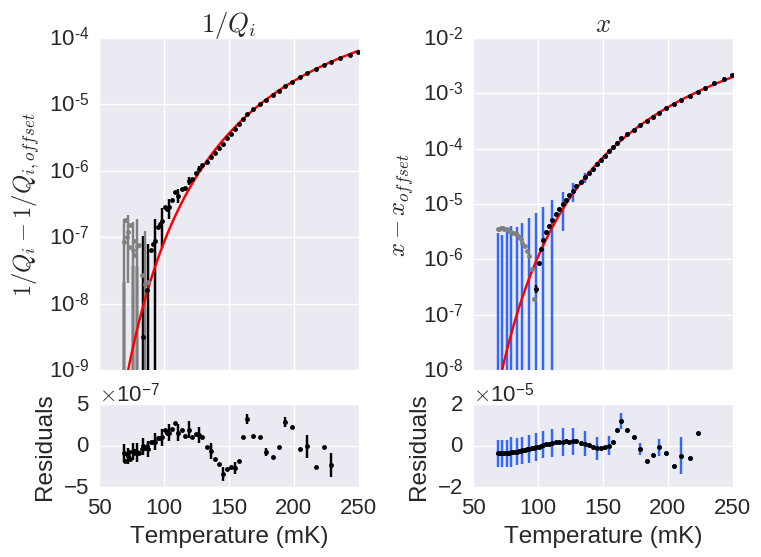

In [57]:
errorevery = 3

from matplotlib import ticker
sns.set(font_scale=1.6)
scale_pow = 2
def my_formatter_fun(x, p):
    return "%.2f" % (x * (10 ** scale_pow))

def eval_params_tls(params,T):
    Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = params
    iqi_predict = iqi(T,alpha_k=alpha_q,Tc=Tc,f=150e6,L0=iqi0,tls_factor=10**tls_q)
    x_predict = xtotal(T,alpha_k=alpha_x,Tc=Tc,f=150e6,x0=x0,tls_factor=10**tls_x)
    return iqi_predict,x_predict
#def plot_results(flatchain):
labels=['Tc','alpha_x','alpha_q','tls_x','tls_q','x0','iqi0','efacx']
Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx = nominal_tls
tls_x=-30
tls_q=-20
#x0 = 1e-7
nominal_copy = np.array([Tc,alpha_x,alpha_q,tls_x,tls_q,x0,iqi0,efacx])
offset_q = iqi0
offset_x = x0#1e-7#0*x0
#efacx=200
gs = matplotlib.gridspec.GridSpec(2,2,height_ratios=[4,1])
fig = plt.figure(figsize=(8,6))
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax1b = fig.add_subplot(gs[0])
ax2b = fig.add_subplot(gs[1])
axs = [ax1b,ax2b,ax3,ax4]
ax1b.xaxis.set_ticklabels([])
ax2b.xaxis.set_ticklabels([])

fig.tight_layout(h_pad=0)
for ax1,ax2 in [(ax1b,ax2b)]:
#    for k in range(100):
#        params = samp.flatchain[np.random.randint(0,samp.flatchain.shape[0]-1),:]
#        iqip,xp = eval_params(params,T)
#        ax1.plot(T*1000,iqip-offset_q,alpha=.05,color='k')
#        ax2.plot(T*1000,xp-offset_x,alpha=.05,color='k')
    iqip,xp = eval_params_tls(nominal_copy,T)
    ax1.plot(T*1000,iqip-offset_q,color='r')
    ax2.plot(T*1000,xp-offset_x,color='r')

    ax1.errorbar(tt*1000,iQi-offset_q,yerr=iQerr,linestyle='',marker='.',color='k',errorevery=errorevery)
    mask = (iQi-offset_q) <0
    ax1.errorbar(tt[mask]*1000,abs(iQi-offset_q)[mask],yerr=iQerr[mask],linestyle='',marker='.',color='gray',errorevery=errorevery)
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err*efacx,linestyle='',color='#3366ff',marker='.',errorevery=errorevery)
    ax2.errorbar(tt*1000,x-offset_x,yerr=x_err,linestyle='',marker='.',color='k',errorevery=errorevery)
    mask = (x-offset_x ) < 0
    ax2.errorbar(tt[mask]*1000,abs(x-offset_x)[mask],yerr=x_err[mask],linestyle='',marker='.',color='gray',errorevery=errorevery)
    ax1.set_ylabel('$1/Q_i-1/Q_{i,offset}$')
    ax2.set_ylabel('$x-x_{offset}$')
ax1b.set_yscale('log')
ax2b.set_yscale('log')
ax1b.set_ylim(1e-9,1e-4)
ax2b.set_ylim(1e-8,1e-2)
#ax1a.set_ylim(1e-9,7e-6)
#ax2a.set_ylim(1e-8,2.5e-4)

iqi_nom,x_nom = eval_params_tls(nominal_copy,tt)
ax3.errorbar(tt*1000,iQi-iqi_nom,yerr=iQerr,linestyle='',marker='.',errorevery=errorevery,color='k')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err*efacx,linestyle='',marker='.',errorevery=errorevery,color='#3366ff')
ax4.errorbar(tt*1000,x-x_nom,yerr=x_err,linestyle='',marker='.',errorevery=errorevery,color='k')
for ax in [ax3,ax4]:
#    ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlabel('Temperature (mK)')
    ax.set_ylabel('Residuals')
#ax1a.set_title('$1/Q_i$ Linear')
#ax2a.set_title('$x$ Linear')
ax1b.set_title('$1/Q_i$')
ax2b.set_title('$x$')
ax1b.xaxis.set_ticklabels([])
ax2b.xaxis.set_ticklabels([])

#ax3.set_title('$1/Q_i$ Residuals')
#ax4.set_title('$x$ Residuals')


ax3.set_ylim(-5e-7,5e-7)
ax4.set_ylim(-2e-5,2e-5)
ax3.yaxis.set_major_locator(MaxNLocator(3))
ax4.yaxis.set_major_locator(MaxNLocator(3))
ax3.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax4.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax3.yaxis.major.formatter._useMathText=True
ax4.yaxis.major.formatter._useMathText=True
for ax in axs:
    #ax.axvline(170,linestyle='--',color='k',alpha=0.7)
    ax.set_xlim(50,250)

fig.tight_layout(h_pad=0)
#fig.subplots_adjust(hspace=0)
fig.savefig('/home/gjones/paper_plots/iqi_x_mb_fits_4_panel.pdf',bbox_inches='tight')

In [154]:
scale

0.0207565982

In [151]:
nominal_exp

array([  2.07565982e-02,  -1.66905351e+01,  -1.97755323e+01,
        -3.03544701e-06,   5.12540650e-06,   5.27963253e+01])

In [152]:
efacx

52.796325299999999

In [153]:
nominal_tls

array([  6.93970797e-01,   1.67801062e-01,   1.06318252e-01,
        -7.31699556e+00,  -7.19529211e+00,   3.65098640e-06,
         5.27108976e-06,   1.29435595e+02])

In [119]:
ax3.ticklabel_format?

In [ ]:
10e